<a href="https://colab.research.google.com/github/nadiarvi/Sentiment-Analysis-using-RNN-and-LSTM/blob/main/Sentiment_Analysis_using_RNN_and_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objectives
* Design an LSTM-based text classification model from scratch using PyTorch.
* Apply the classification model to a popular classification task, sentiment analysis.
* Use Huggingface Library (`transformers`) to leverage self-supervision via large language models.

## Download Train Dataset

In [1]:
import os
import sys
import ssl
import urllib.request

In [2]:
def _download_dataset(size=10000):
    assert sys.version_info >= (3, 6), "Use Python3.6+"

    url = f"https://raw.githubusercontent.com/dongkwan-kim/small_dataset/master/review_{size // 1000}k.csv"

    dir_path = "../data"
    file_path = os.path.join(dir_path, f"review_{size // 1000}k.csv")
    if not os.path.isfile(file_path):
        print(f"Download: {file_path}")
        os.makedirs(dir_path, exist_ok=True)
        ctx = ssl._create_unverified_context()
        with urllib.request.urlopen(url, context=ctx) as u, open(file_path, "wb") as f:
            f.write(u.read())
    else:
        print(f"Already exist: {file_path}")

In [3]:
_download_dataset()

Download: ../data/review_10k.csv


## Environment Setting

In [4]:
! pip install transformers[torch] datasets evaluate accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [5]:
import time
import random

from tqdm.auto import tqdm
from easydict import EasyDict

import torch
import torch.nn as nn
import torch.optim as optim

from torch.nn.utils.rnn import pack_padded_sequence
from torch.utils.data import DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from datasets import load_dataset

In [6]:
def seed_reset(seed=0):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
seed_reset(42)

# LSTM

## Utils for Text Classification using LSTM

In [8]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [9]:
def accuracy(prediction, label):
    binary_prediction = torch.round(torch.sigmoid(prediction))
    correct = (binary_prediction == label).float()
    acc = correct.sum() / len(correct)
    return acc

In [10]:
def _load_dataset_for_LSTM(batch_size, num_samples=10000, train_test_ratio=0.8, seed=42, test_data_path=None):
    dataset = load_dataset("csv", data_files=f"../data/review_{num_samples // 1000}k.csv", split="train")
    dataset = dataset.train_test_split(test_size=1 - train_test_ratio, seed=seed)
    train_dataset, validation_dataset = dataset["train"], dataset["test"]

    tokenizer = get_tokenizer("basic_english")

    # Build vocabulary
    def yield_tokens(data_iter):
        for sample in data_iter:
            yield tokenizer(sample["review"])

    vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>", "<pad>"])
    vocab.set_default_index(vocab["<unk>"])

    # Tokenize & Build data loader
    def data_collator(batch):
        texts, text_lengths, sentiments = [], [], []
        for sample in batch:
            tokenized_text = vocab(tokenizer(sample['review']))
            texts.append(tokenized_text)
            text_lengths.append(len(tokenized_text))
            sentiments.append(sample['sentiment'])

        text_batch = torch.zeros(len(batch), max(text_lengths), dtype=torch.int64)
        length_batch, sentiment_batch = [], []
        for i, (text, length, sentiment) in enumerate(sorted(zip(texts, text_lengths, sentiments), key=lambda x: x[1], reverse=True)):
            for j, word in enumerate(text):
                text_batch[i][j] = text[j]
            length_batch.append(length)
            sentiment_batch.append(sentiment)

        batch = EasyDict()
        batch.review = (text_batch, length_batch)
        batch.sentiment = torch.tensor(sentiment_batch, dtype=torch.float64)
        return batch

    train_dataloader = DataLoader(
        train_dataset, shuffle=False, collate_fn=data_collator, batch_size=batch_size
    )
    validation_dataloader = DataLoader(
        validation_dataset, shuffle=False, collate_fn=data_collator, batch_size=batch_size
    )

    test_dataloader = None
    if test_data_path != None:
        test_dataset = load_dataset('csv', data_files=test_data_path, split='train')
        test_dataloader = DataLoader(
            test_dataset, shuffle=False, collate_fn=data_collator, batch_size=batch_size
        )

    return train_dataloader, validation_dataloader, test_dataloader, len(vocab), vocab(["<pad>"])[0]

## Implement LSTM with PyTorch

In [11]:
class RNN(nn.Module):

    def __init__(self, num_embeddings, padding_idx, embedding_dim,
                 hidden_dim, num_layers, dropout, bidirectional):
        """
        :param num_embeddings: the numebr of embeddings (vocab size)
        :param padding_idx: padding idx
        :param embedding_dim: (int) embedding dimension
        :param hidden_dim: (int) hidden dimension
        :param num_layers: (int) the number of recurrent layers
        :param dropout: (float) dropout rate
        :param bidirectional: (bool) is bidirectional

        :return output: type=torch.Tensor, shape=[batch size]
        """

        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim, padding_idx=padding_idx)
        self.dropout = nn.Dropout(dropout)

        self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True, bidirectional=bidirectional)

        out = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(out, 1)


    def forward(self, text, text_lengths):

        embedded = self.dropout(self.embedding(text))

        packed_embedded = pack_padded_sequence(embedded, text_lengths, batch_first=True)

        output, (h_n, c_n) = self.rnn(packed_embedded)

        sec_last_layer = h_n[-2,:,:]
        last_layer = h_n[-1,:,:]

        if self.rnn.bidirectional:
        # Concatenate forward and backward if bidirectional
          h_n = torch.cat((sec_last_layer, last_layer), dim=1)
        else:
          h_n = last_layer

        output = self.fc(h_n).squeeze(-1)


        assert output.shape == torch.Size([text.shape[0]]) # batch_size
        return output

In [12]:
def train(model, iterator, optimizer, criterion, device):
    """ Complete train method
    :param model: RNN model
    :param iterator: train dataset iterator
    :param optimizer: optimzer
    :param criterion: loss function

    :return output: train loss, train accuracy
    """

    total_epoch_loss = 0
    total_epoch_acc = 0

    model.train()

    for batch in tqdm(iterator, desc="train"):

        optimizer.zero_grad()
        (text, text_lengths), labels = batch.review, batch.sentiment
        text = text.to(device)
        labels = labels.to(device)

        # prediction
        predictions = model(text, text_lengths).squeeze(-1)

        # loss
        loss = criterion(predictions, labels.float())

        # accuracy
        acc = accuracy(predictions, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        assert loss.shape == torch.Size([])
        assert acc.shape == torch.Size([])

        total_epoch_loss += loss.item()
        total_epoch_acc += acc.item()


    epoch_loss = total_epoch_loss / len(iterator)
    epoch_acc = total_epoch_acc / len(iterator)
    return epoch_loss, epoch_acc


In [13]:
def evaluate(model, iterator, criterion, device):
    """ Complete evaluate method
    :param model: RNN model
    :param iterator: dataset iterator
    :param criterion: loss function

    :return output: loss, accuracy
    """

    total_epoch_loss = 0
    total_epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for batch in tqdm(iterator, desc="evaluate"):
            (text, text_lengths), labels = batch.review, batch.sentiment
            text = text.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(text, text_lengths).squeeze(-1)

            # loss
            loss = criterion(predictions, labels.float())

            # accuracy
            acc = accuracy(predictions, labels)

            assert loss.shape == torch.Size([])
            assert acc.shape == torch.Size([])

            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()

    epoch_loss = total_epoch_loss / len(iterator)
    epoch_acc = total_epoch_acc / len(iterator)
    return epoch_loss, epoch_acc

In [14]:
def run_LSTM(hyperparameter_dict, num_samples=10000, train=train, evaluate=evaluate, seed=0, test_data_path=None, verbose=True):
    """
    You do not have to consider test_data_path, since it will be used for grading only.
    You can modify this run function for training your own model in the marked area below.
    """
    train_loader, valid_loader, test_loader, vocab_size, padding_idx = _load_dataset_for_LSTM(hyperparameter_dict.batch_size, num_samples, seed=seed, test_data_path=test_data_path)

    NUM_EMBEDDINGS = vocab_size
    PADDING_IDX = padding_idx

    model = RNN(NUM_EMBEDDINGS,
                PADDING_IDX,
                hyperparameter_dict.embedding_dim,
                hyperparameter_dict.hidden_dim,
                hyperparameter_dict.num_layers,
                hyperparameter_dict.dropout,
                hyperparameter_dict.bidirectional
                )

    device = torch.device(hyperparameter_dict.device if torch.cuda.is_available() else 'cpu')

    train_loss, train_acc = None, None
    valid_loss, valid_acc = None, None
    test_loss, test_acc = None, None

    optimizer = optim.Adam(model.parameters(), lr=hyperparameter_dict.learning_rate)
    criterion = nn.BCEWithLogitsLoss()
    model = model.to(device)
    criterion = criterion.to(device)

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    for epoch in range(hyperparameter_dict.num_epochs):
        print(f'Epoch: {epoch+1:02}')
        start_time = time.time()

        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        valid_loss, valid_acc = evaluate(model, valid_loader, criterion, device)

        if verbose:
            end_time = time.time()
            epoch_mins, epoch_secs = epoch_time(start_time, end_time)
            print(f'\nEpoch Time: {epoch_mins}m {epoch_secs}s')
            print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
            print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')
            train_loss_list.append(train_loss)
            train_acc_list.append(train_acc)
            val_loss_list.append(valid_loss)
            val_acc_list.append(valid_acc)

    if test_loader != None:
        test_loss, test_acc = evaluate(model, test_loader, criterion)
        print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

    return train_loss, train_acc, valid_loss, valid_acc, test_loss, test_acc, train_loss_list, train_acc_list, val_loss_list, val_acc_list


## Run LSTM

In [15]:
def set_hyperparameter_for_LSTM():
    """
    Set your best hyperparameters for your model
    """
    param_dict = EasyDict()
    param_dict.embedding_dim = 128
    param_dict.hidden_dim = 64
    param_dict.num_layers = 2
    param_dict.dropout = 0.4
    param_dict.bidirectional = True
    param_dict.batch_size = 64
    param_dict.num_epochs = 50
    param_dict.learning_rate = 1e-3
    param_dict.device = 'cuda'
    return param_dict

In [16]:
param_dict = set_hyperparameter_for_LSTM()
_, _, _, _, _, _, train_loss_list, train_acc_list, val_loss_list, val_acc_list = run_LSTM(param_dict)

Generating train split: 0 examples [00:00, ? examples/s]

Epoch: 01


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 57s
	Train Loss: 0.678 | Train Acc: 56.15%
	 Val. Loss: 0.686 |  Val. Acc: 56.98%
Epoch: 02


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.630 | Train Acc: 64.61%
	 Val. Loss: 0.603 |  Val. Acc: 65.92%
Epoch: 03


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.566 | Train Acc: 70.60%
	 Val. Loss: 0.548 |  Val. Acc: 72.36%
Epoch: 04


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 37s
	Train Loss: 0.512 | Train Acc: 74.65%
	 Val. Loss: 0.519 |  Val. Acc: 72.85%
Epoch: 05


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.476 | Train Acc: 77.74%
	 Val. Loss: 0.850 |  Val. Acc: 63.13%
Epoch: 06


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.400 | Train Acc: 82.11%
	 Val. Loss: 0.861 |  Val. Acc: 68.70%
Epoch: 07


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.363 | Train Acc: 84.28%
	 Val. Loss: 0.488 |  Val. Acc: 81.88%
Epoch: 08


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 34s
	Train Loss: 0.334 | Train Acc: 85.41%
	 Val. Loss: 0.733 |  Val. Acc: 76.71%
Epoch: 09


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.270 | Train Acc: 88.78%
	 Val. Loss: 0.454 |  Val. Acc: 83.15%
Epoch: 10


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.239 | Train Acc: 90.39%
	 Val. Loss: 0.573 |  Val. Acc: 81.84%
Epoch: 11


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 36s
	Train Loss: 0.225 | Train Acc: 90.75%
	 Val. Loss: 0.496 |  Val. Acc: 83.50%
Epoch: 12


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.185 | Train Acc: 92.69%
	 Val. Loss: 0.525 |  Val. Acc: 84.33%
Epoch: 13


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.168 | Train Acc: 93.16%
	 Val. Loss: 0.520 |  Val. Acc: 84.28%
Epoch: 14


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.156 | Train Acc: 93.86%
	 Val. Loss: 0.507 |  Val. Acc: 83.64%
Epoch: 15


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.144 | Train Acc: 94.50%
	 Val. Loss: 0.534 |  Val. Acc: 85.21%
Epoch: 16


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.134 | Train Acc: 94.80%
	 Val. Loss: 0.560 |  Val. Acc: 84.86%
Epoch: 17


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.111 | Train Acc: 95.81%
	 Val. Loss: 0.577 |  Val. Acc: 84.38%
Epoch: 18


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.107 | Train Acc: 95.95%
	 Val. Loss: 0.571 |  Val. Acc: 85.30%
Epoch: 19


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.091 | Train Acc: 96.74%
	 Val. Loss: 0.598 |  Val. Acc: 85.06%
Epoch: 20


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.093 | Train Acc: 96.59%
	 Val. Loss: 0.439 |  Val. Acc: 84.28%
Epoch: 21


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.101 | Train Acc: 96.17%
	 Val. Loss: 0.801 |  Val. Acc: 82.52%
Epoch: 22


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.080 | Train Acc: 97.06%
	 Val. Loss: 0.789 |  Val. Acc: 83.40%
Epoch: 23


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.057 | Train Acc: 97.91%
	 Val. Loss: 0.684 |  Val. Acc: 85.06%
Epoch: 24


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 36s
	Train Loss: 0.053 | Train Acc: 98.10%
	 Val. Loss: 0.721 |  Val. Acc: 84.13%
Epoch: 25


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 36s
	Train Loss: 0.055 | Train Acc: 98.09%
	 Val. Loss: 0.843 |  Val. Acc: 83.98%
Epoch: 26


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.051 | Train Acc: 98.25%
	 Val. Loss: 0.677 |  Val. Acc: 85.99%
Epoch: 27


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.056 | Train Acc: 97.92%
	 Val. Loss: 0.846 |  Val. Acc: 85.74%
Epoch: 28


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.041 | Train Acc: 98.54%
	 Val. Loss: 0.720 |  Val. Acc: 85.89%
Epoch: 29


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 36s
	Train Loss: 0.038 | Train Acc: 98.61%
	 Val. Loss: 0.683 |  Val. Acc: 86.57%
Epoch: 30


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 51s
	Train Loss: 0.035 | Train Acc: 98.76%
	 Val. Loss: 0.763 |  Val. Acc: 86.04%
Epoch: 31


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 1m 3s
	Train Loss: 0.041 | Train Acc: 98.61%
	 Val. Loss: 0.802 |  Val. Acc: 85.16%
Epoch: 32


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 1m 1s
	Train Loss: 0.033 | Train Acc: 98.91%
	 Val. Loss: 0.763 |  Val. Acc: 85.69%
Epoch: 33


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 46s
	Train Loss: 0.032 | Train Acc: 98.86%
	 Val. Loss: 0.786 |  Val. Acc: 85.64%
Epoch: 34


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 37s
	Train Loss: 0.030 | Train Acc: 98.78%
	 Val. Loss: 0.916 |  Val. Acc: 84.91%
Epoch: 35


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.033 | Train Acc: 98.70%
	 Val. Loss: 0.948 |  Val. Acc: 82.62%
Epoch: 36


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 37s
	Train Loss: 0.025 | Train Acc: 99.16%
	 Val. Loss: 1.140 |  Val. Acc: 81.64%
Epoch: 37


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.022 | Train Acc: 99.19%
	 Val. Loss: 0.890 |  Val. Acc: 85.16%
Epoch: 38


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.021 | Train Acc: 99.36%
	 Val. Loss: 0.813 |  Val. Acc: 85.84%
Epoch: 39


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.019 | Train Acc: 99.31%
	 Val. Loss: 1.160 |  Val. Acc: 82.32%
Epoch: 40


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.018 | Train Acc: 99.38%
	 Val. Loss: 0.939 |  Val. Acc: 84.08%
Epoch: 41


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.015 | Train Acc: 99.52%
	 Val. Loss: 0.948 |  Val. Acc: 84.42%
Epoch: 42


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 36s
	Train Loss: 0.013 | Train Acc: 99.56%
	 Val. Loss: 1.022 |  Val. Acc: 84.57%
Epoch: 43


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 36s
	Train Loss: 0.019 | Train Acc: 99.30%
	 Val. Loss: 0.868 |  Val. Acc: 85.89%
Epoch: 44


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 36s
	Train Loss: 0.021 | Train Acc: 99.28%
	 Val. Loss: 0.840 |  Val. Acc: 85.79%
Epoch: 45


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.012 | Train Acc: 99.58%
	 Val. Loss: 0.998 |  Val. Acc: 84.18%
Epoch: 46


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.018 | Train Acc: 99.44%
	 Val. Loss: 0.901 |  Val. Acc: 85.55%
Epoch: 47


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 35s
	Train Loss: 0.014 | Train Acc: 99.50%
	 Val. Loss: 0.822 |  Val. Acc: 86.18%
Epoch: 48


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 36s
	Train Loss: 0.011 | Train Acc: 99.62%
	 Val. Loss: 0.827 |  Val. Acc: 86.18%
Epoch: 49


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 36s
	Train Loss: 0.010 | Train Acc: 99.67%
	 Val. Loss: 0.886 |  Val. Acc: 86.47%
Epoch: 50


train:   0%|          | 0/125 [00:00<?, ?it/s]

evaluate:   0%|          | 0/32 [00:00<?, ?it/s]


Epoch Time: 0m 36s
	Train Loss: 0.010 | Train Acc: 99.65%
	 Val. Loss: 0.834 |  Val. Acc: 85.94%


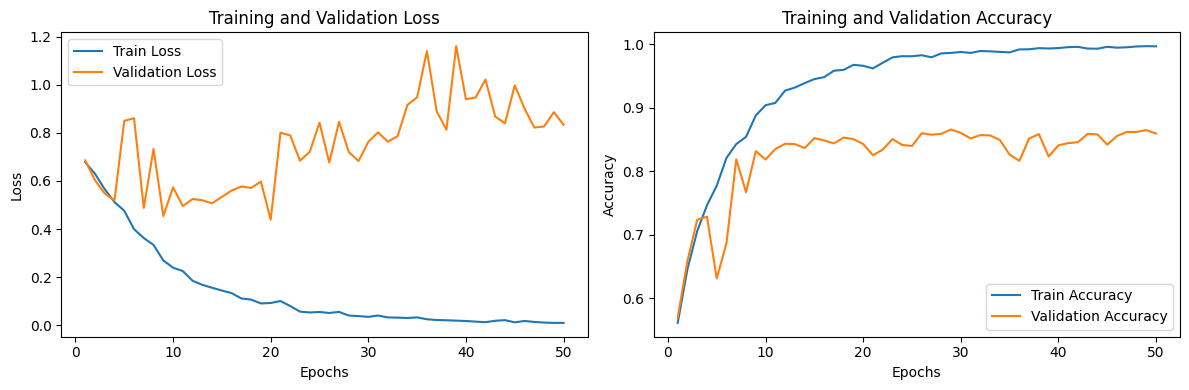

In [24]:
import matplotlib.pyplot as plt

def visualize_trends(train_loss_list, train_acc_list, val_loss_list, val_acc_list):
    epochs = range(1, len(train_loss_list) + 1)

    # Plotting train loss and validation loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_list, label='Train Loss')
    plt.plot(epochs, val_loss_list, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks()
    plt.legend()

    # Plotting train accuracy and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_list, label='Train Accuracy')
    plt.plot(epochs, val_acc_list, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks()
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call the visualize_trends function
visualize_trends(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

# BERT

## Utils for Text Classification using Huggingface Libary

In [18]:
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=-1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred, average="weighted")
    precision = precision_score(y_true=labels, y_pred=pred, average="weighted")
    f1 = f1_score(y_true=labels, y_pred=pred, average="weighted")
    return {"accuracy": accuracy, "recall": recall, "precision": precision, "f1": f1}

## Use Huggingface Library

In [19]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

In [20]:
def _load_dataset_for_BERT(tokenizer_name, num_samples=10000, train_test_ratio=0.8, seed=42, test_data_path=None):

    class CustomDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels
        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item
        def __len__(self):
            return len(self.labels)

    def preprocess(tokenizer, dataset):
        return tokenizer(dataset, truncation=True)

    dataset = load_dataset("csv", data_files=f"../data/review_{num_samples // 1000}k.csv", split="train")
    dataset = dataset.train_test_split(test_size=1 - train_test_ratio, seed=seed)
    train_dataset, eval_dataset = dataset["train"], dataset["test"]

    tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    train_encodings, eval_encodings, test_encodings = preprocess(tokenizer, train_dataset['review']), preprocess(tokenizer, eval_dataset['review']), None
    train_dataset, eval_dataset, test_dataset = CustomDataset(train_encodings, train_dataset['sentiment']), CustomDataset(eval_encodings, eval_dataset['sentiment']), None

    if test_data_path is not None:
        test_dataset = load_dataset("csv", data_files=test_data_path, split="train")
        test_encodings = preprocess(tokenizer, test_dataset['review'])
        test_dataset = CustomDataset(test_encodings, test_dataset['sentiment'])

    return train_dataset, eval_dataset, test_dataset

In [25]:
def run_BERT(model_name, args, num_samples=10000, seed=0, test_data_path=None, verbose=True):
    """
    You do not have to consider test_data_path, since it will be used for grading only.
    You can modify this run function for training your own model in the marked area below.
    """
    train_dataset, eval_dataset, test_dataset = _load_dataset_for_BERT(model_name, num_samples, seed=seed, test_data_path=test_data_path)

    # model
    model = AutoModelForSequenceClassification.from_pretrained(model_name)

    # tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Trainer
    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    test_loss = None
    test_acc = None

    train_loss_list = []
    train_acc_list = []
    val_loss_list = []
    val_acc_list = []

    trainer.train()
    eval_result = trainer.evaluate(eval_dataset)
    eval_loss, eval_acc = eval_result['eval_loss'], eval_result['eval_accuracy']



    if test_dataset is not None: # then this will be None since test_data_path is None?
        test_result = trainer.predict(test_dataset)
        test_loss, test_acc = test_result['eval_loss'], test_result['eval_accuracy']
        print(f'\t Test Loss: {test_loss:.3f} |  Test Acc: {test_acc*100:.2f}%')

        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(eval_loss)
        val_acc_list.append(eval_acc)

    return eval_loss, eval_acc, test_loss, test_acc, train_loss_list, train_acc_list, val_loss_list, val_acc_list

## Run BERT

In [26]:
def set_hyperparameter_for_BERT():
    """ Set your best hyperparameters for your model
    """
    args = TrainingArguments(
        output_dir='./DistilBERT/',
        learning_rate=1e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
    )
    return args

In [27]:
args = set_hyperparameter_for_BERT()
_, _, _, _, _, _, train_loss_list, train_acc_list, val_loss_list, val_acc_list = run_BERT('distilbert-base-cased', args)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.bias', 'classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,0.279805,0.895000,0.895000,0.896310,0.894845
2,0.311900,0.265944,0.904000,0.904000,0.904863,0.903994


Epoch,Training Loss,Validation Loss,Accuracy,Recall,Precision,F1
1,No log,0.279805,0.895000,0.895000,0.896310,0.894845
2,0.311900,0.265944,0.904000,0.904000,0.904863,0.903994
3,0.311900,0.282051,0.903000,0.903000,0.903022,0.902988
4,0.142300,0.311100,0.901500,0.901500,0.901798,0.901508
5,0.142300,0.324709,0.904000,0.904000,0.904059,0.904007


ValueError: not enough values to unpack (expected 10, got 8)

In [1]:
visualize_trends(train_loss_list, train_acc_list, val_loss_list, val_acc_list)

NameError: name 'visualize_trends' is not defined